# Example binary phase diagram from histogram combination notebook for FHMCAnalysis
* Author: Nathan A. Mahynski
* Last Modified: 05/02/17

In [2]:
import sys, os, json, copy
import numpy as np
sys.path.append('../../../../')
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.chkpt_patch as wP
import FHMCAnalysis.moments.win_patch.chkpt_equil as wE
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_binary as gB
import random
from scipy.signal import argrelextrema
from matplotlib.patches import Ellipse

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Compute Phase Diagrams From Combined Simulations

In [2]:
lnZ_tol = 1.0e-5 # Error tolerance for free energy difference between coexisting phases
order = 2 # Order of extrapolation

In [3]:
# Dictionaries to store data
mu1_guesses = {}
rho = {}
P = {}
x1 = {}
d2 = {}
V = {}
loaded = False

## Load mu1_guesses if have gone through this notebook once already
```
f = open('mu1_guesses.dat', 'r')
mu1_tmp = json.load(f)
f.close()

mu1_guesses = {}
for key in mu1_tmp:
    mu1_guesses[float(key)] = {}
    for key2 in mu1_tmp[key]:
        mu1_guesses[float(key)][float(key2)] = mu1_tmp[key][key2]

loaded = True
```

# Consider T = 1.20

In [4]:
temp = 1.20

In [5]:
head = './T=%2.2f'%temp
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0

histograms1 = {}
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    composite = head+'/'+d+'/composite.nc'
    try:
        f = open(composite,'r')
    except:
        pass
    else:
        dMu2 = float(d.split('_')[1])
        hist = hG.histogram (fname=composite, beta_ref=beta_ref, mu_ref=[0.0, 0.0+dMu2], smooth=smooth)
        histograms1[dMu2] = hist

if (not loaded): # For initial estimates
    mu1_guesses[temp] = {}

## Example of Manual Estimation of mu_1 for Each Delta mu_2

```
dmu_vec = sorted([d for d in histograms1])
print dmu_vec

i = 14 # Choose an index of dmu_vec to estimate coexistence along

dmu2 = dmu_vec[i]
print 'Examining '+r'$\Delta \mu_2 = %2.4f$'%dmu2
for mu1 in np.linspace(-7.5, -3, 10): # Pick some range of mu_1 to look for "double peaked" ln(PI)
    histograms1[dmu2].reweight(mu1)
    plt.plot(histograms1[dmu2].data['ln(PI)'], label=mu1)
plt.legend(bbox_to_anchor=(1.5,1))

mu1_g = -7.3 # From the graph, guess some mu_1 to start iterations from, until the function value < 100 (should ~0)
if (not loaded):
    coex = histograms1[dmu2].find_phase_eq(lnZ_tol, mu1_g, beta_ref, np.array([dmu2]), order)
    mu1_guesses[temp][dmu2] = coex.data['curr_mu'][0]

# Go back to do the next i index, repeat until all indices have been completed
# Note that this manual process can be automated as the user sees fit, see find_phase_eq() documentation
```

## Alternative Automatic Estimation of Coexistence

In [6]:
tol = 0.005
if (not loaded):
    dmu_vec = sorted([d for d in histograms1])
    
    for i in range(len(dmu_vec)):
        dmu2 = dmu_vec[i]
        
        # Guess a range of mu_1 values to search over
        if (i > 0):
            # Later loops, use last point as a guess
            end = last_guess - 0.65 # Can modify guessing range as needed
            start = last_guess + 0.65 # Can modify guessing range as needed
            nstep = 20
        else:
            # First loop, search broadly
            end = -11 # Can modify guessing range as needed
            start = -3 # Can modify guessing range as needed
            nstep = 100
            
        found = False
        for mu1_g in np.linspace(start, end, nstep): 
            coex, err = histograms1[dmu2].find_phase_eq(lnZ_tol, mu1_g, beta_ref, np.array([dmu2]), order, 10.0, override=False, reterr=True)
            if (err < tol):
                mu1_guesses[temp][dmu2] = coex.data['curr_mu'][0]
                last_guess = mu1_guesses[temp][dmu2]
                found = True
                break
                
        if (not found):
            raise Exception("Unable to locate coexistence for dmu2 = %3.4f"%dmu2)
        else:
            print 'FOUND COEXISTENCE AT (mu1,dmu2) = (%3.4f'%mu1_guesses[temp][dmu2]+',%3.4f'%dmu2+')'
            

Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 14
         Function evaluations: 41
Optimization termina

## Compute Phase Equilibrium

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 15
         Function evaluations: 31
Optimization terminated successful

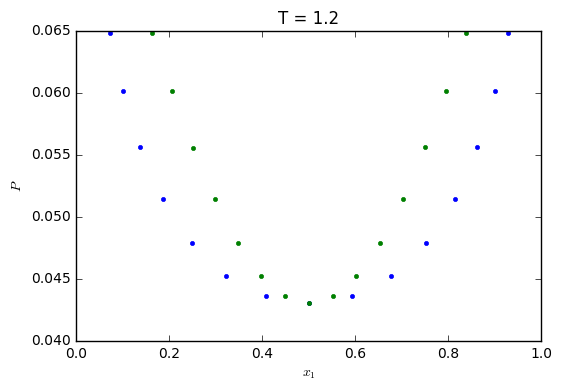

In [8]:
rho[temp] = []
P[temp] = []
x1[temp] = []
d2[temp] = []
V[temp] = 9.0**3 # Volume of simulation cell in provided data

for dmu2 in sorted(histograms1):
    try:
        coex = histograms1[dmu2].find_phase_eq(lnZ_tol, mu1_guesses[temp][dmu2], beta_ref, np.array([dmu2]), order)
    except Exception as e:
        print e
        print 'Error on ', dmu2
    else:
        assert (len(coex.data['thermo']) == 2), 'Found '+str(len(coex.data['thermo']))+'phases instead of 2'
        rho[temp].append([coex.data['thermo'][0]['density'], coex.data['thermo'][1]['density']])
        P[temp].append([-coex.data['thermo'][0]['F.E./kT']/V[temp]*temp, -coex.data['thermo'][1]['F.E./kT']/V[temp]*temp])
        x1[temp].append([coex.data['thermo'][0]['x1'], coex.data['thermo'][1]['x1']])
        d2[temp].append(dmu2)

plt.plot([a[0] for a in x1[temp]], [b[0] for b in P[temp]], '.')
plt.plot([a[1] for a in x1[temp]], [b[1] for b in P[temp]], '.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$P$')
plt.title('T = '+str(temp))

# Consider T = 1.10

In [14]:
temp = 1.10

In [15]:
head = './T=%2.2f'%temp
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0
smooth = 30 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms2 = {}
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    composite = head+'/'+d+'/composite.nc'
    try:
        f = open(composite,'r')
    except:
        pass
    else:
        dMu2 = float(d.split('_')[1])
        mu_ref = [0.0, 0.0+dMu2] # Simulations were performed at mu_1 = 0
        hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
        histograms2[dMu2] = hist
        
if (not loaded): # For initial estimates
    mu1_guesses[temp] = {}

## Alternative Automatic Estimation of Coexistence

In [20]:
tol = 0.005
if (not loaded):
    dmu_vec = sorted([d for d in histograms2])
    
    for i in range(len(dmu_vec)):
        dmu2 = dmu_vec[i]
        
        # Guess a range of mu_1 values to search over
        if (i > 0):
            # Later loops, use last point as a guess
            end = last_guess - 0.65 # Can modify guessing range as needed
            start = last_guess + 0.65 # Can modify guessing range as needed
            nstep = 20
        else:
            # First loop, search broadly
            end = -11 # Can modify guessing range as needed
            start = -3 # Can modify guessing range as needed
            nstep = 100
            
        found = False
        for mu1_g in np.linspace(start, end, nstep): 
            coex, err = histograms2[dmu2].find_phase_eq(lnZ_tol, mu1_g, beta_ref, np.array([dmu2]), order, 10.0, override=False, reterr=True)
            if (err < tol):
                mu1_guesses[temp][dmu2] = coex.data['curr_mu'][0]
                last_guess = mu1_guesses[temp][dmu2]
                found = True
                break
    
        if (not found):
            raise Exception("Unable to locate coexistence for dmu2 = %3.4f"%dmu2)
        else:
            print 'FOUND COEXISTENCE AT (mu1,dmu2) = (%3.4f'%mu1_guesses[temp][dmu2]+',%3.4f'%dmu2+')'
            

Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization termina

## Compute phase equilibrium

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

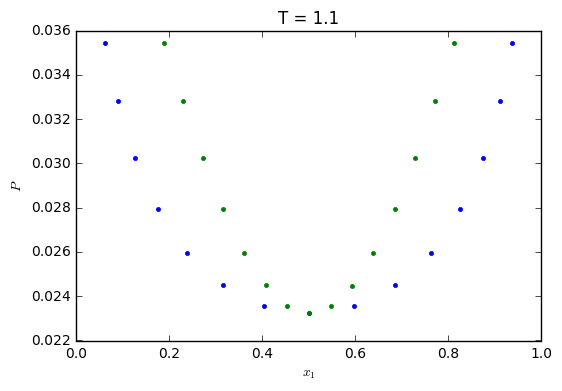

In [22]:
rho[temp] = []
P[temp] = []
x1[temp] = []
d2[temp] = []
V[temp] = 9.0**3

for dmu2 in sorted(histograms2):
    try:
        coex = histograms2[dmu2].find_phase_eq(lnZ_tol, mu1_guesses[temp][dmu2], beta_ref, np.array([dmu2]), order)
    except Exception as e:
        print e
        print 'Error on ', dmu2
    else:
        assert (len(coex.data['thermo']) == 2), 'Found '+str(len(coex.data['thermo']))+'phases instead of 2'
        rho[temp].append([coex.data['thermo'][0]['density'], coex.data['thermo'][1]['density']])
        P[temp].append([-coex.data['thermo'][0]['F.E./kT']/V[temp]*temp, -coex.data['thermo'][1]['F.E./kT']/V[temp]*temp])
        x1[temp].append([coex.data['thermo'][0]['x1'], coex.data['thermo'][1]['x1']])
        d2[temp].append(dmu2)
        
plt.plot([a[0] for a in x1[temp]], [b[0] for b in P[temp]], '.')
plt.plot([a[1] for a in x1[temp]], [b[1] for b in P[temp]], '.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$P$')
plt.title('T = '+str(temp))

# Consider T = 0.95

In [27]:
temp = 0.95

In [28]:
head = './T=%2.2f'%temp
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0
smooth = 30 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms3 = {}
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    composite = head+'/'+d+'/composite.nc'
    try:
        f = open(composite,'r')
    except:
        pass
    else:
        dMu2 = float(d.split('_')[1])
        mu_ref = [0.0, dMu2] # Simulations were performed at mu_1 = 0
        hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
        histograms3[dMu2] = hist
        
if (not loaded): # For initial estimates
    mu1_guesses[temp] = {}

## Alternative Automatic Estimation of Coexistence

In [29]:
tol = 0.005
if (not loaded):
    dmu_vec = sorted([d for d in histograms3])
    
    for i in range(len(dmu_vec)):
        dmu2 = dmu_vec[i]
        
        # Guess a range of mu_1 values to search over
        if (i > 0):
            # Later loops, use last point as a guess
            end = last_guess - 0.65 # Can modify guessing range as needed
            start = last_guess + 0.65 # Can modify guessing range as needed
            nstep = 20
        else:
            # First loop, search broadly
            end = -11 # Can modify guessing range as needed
            start = -3 # Can modify guessing range as needed
            nstep = 100
            
        found = False
        for mu1_g in np.linspace(start, end, nstep): 
            coex, err = histograms3[dmu2].find_phase_eq(lnZ_tol, mu1_g, beta_ref, np.array([dmu2]), order, 10.0, override=False, reterr=True)
            if (err < tol):
                mu1_guesses[temp][dmu2] = coex.data['curr_mu'][0]
                last_guess = mu1_guesses[temp][dmu2]
                found = True
                break
    
        if (not found):
            raise Exception("Unable to locate coexistence for dmu2 = %3.4f"%dmu2)
        else:
            print 'FOUND COEXISTENCE AT (mu1,dmu2) = (%3.4f'%mu1_guesses[temp][dmu2]+',%3.4f'%dmu2+')'
            

Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 100.000000
         Iterations: 12
         Function evaluations: 34
Optimization termina

## Compute phase equilibrium

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

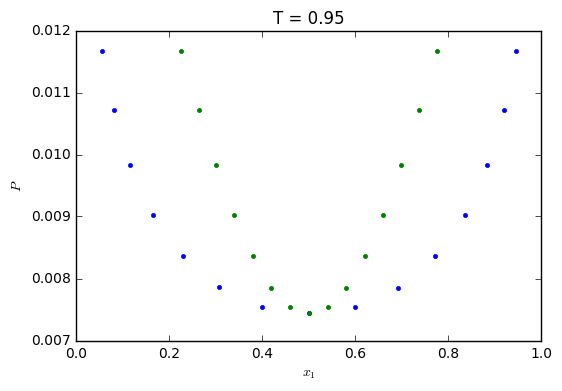

In [30]:
rho[temp] = []
P[temp] = []
x1[temp] = []
d2[temp] = []
V[temp] = 9.0**3

for dmu2 in sorted(histograms3):
    try:
        coex = histograms3[dmu2].find_phase_eq(lnZ_tol, mu1_guesses[temp][dmu2], beta_ref, np.array([dmu2]), order)
    except Exception as e:
        print e
        print 'Error on ', dmu2
    else:
        assert (len(coex.data['thermo']) == 2), 'Found '+str(len(coex.data['thermo']))+'phases instead of 2'
        rho[temp].append([coex.data['thermo'][0]['density'], coex.data['thermo'][1]['density']])
        P[temp].append([-coex.data['thermo'][0]['F.E./kT']/V[temp]*temp, -coex.data['thermo'][1]['F.E./kT']/V[temp]*temp])
        x1[temp].append([coex.data['thermo'][0]['x1'], coex.data['thermo'][1]['x1']])
        d2[temp].append(dmu2)
        
plt.plot([a[0] for a in x1[temp]], [b[0] for b in P[temp]], '.')
plt.plot([a[1] for a in x1[temp]], [b[1] for b in P[temp]], '.')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$P$')
plt.title('T = '+str(temp))

# Plot it all together

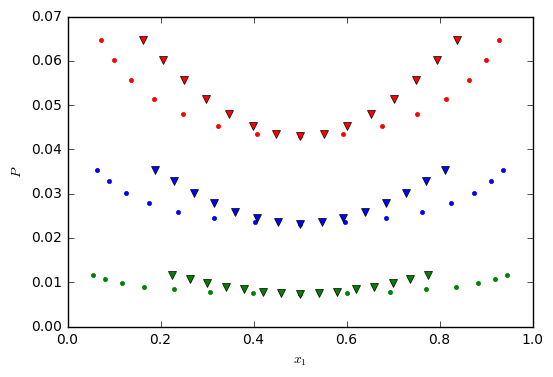

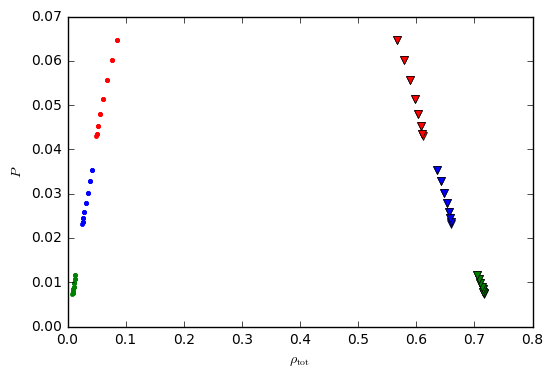

In [32]:
colors = {1.2: 'r', 1.1:'b', 0.95:'g'}

plt.figure()
for temp in [1.20, 1.10, 0.95]:
    plt.plot([a[0] for a in x1[temp]], [b[0] for b in P[temp]], marker='.', lw=0, color=colors[temp])
    plt.plot([a[1] for a in x1[temp]], [b[1] for b in P[temp]], marker='v', lw=0, color=colors[temp])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$P$')

plt.figure()
for temp in [1.20, 1.10, 0.95]:
    plt.plot([a[0] for a in rho[temp]], [b[0] for b in P[temp]], marker='.', lw=0, color=colors[temp])
    plt.plot([a[1] for a in rho[temp]], [b[1] for b in P[temp]], marker='v', lw=0, color=colors[temp])
plt.xlabel(r'$\rho_{\rm tot}$')
plt.ylabel(r'$P$')

In [33]:
# Save mu1_guesses for next time

if (not loaded):
    import json
    f = open('mu1_guesses.dat', 'w')
    json.dump(mu1_guesses, f, sort_keys=True, indent=4)
    f.close()

# Perform Extrapolation from a Single T

In [37]:
beta_ref = 1.0/1.20 # Choose a high temperature state, T = [0.95, 1.10, 1.20]
mu_ref = [0.0, 0.0] # Choose a (mu1, mu2)
first_order_mom = True # Use only first order extrapolation to predict moments

In [38]:
smooth = 30
Vol = V[1.0/beta_ref]
hist_ref = hG.histogram ('./T=%.2f'%(1.0/beta_ref)+'/dMu2_%.4f'%mu_ref[1]+'/composite.nc', beta_ref, mu_ref, smooth)
tol = 0.005
maxiter = 30
flex = 0.3

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 32
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 15
         Function evaluations: 32
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 34
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 34
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 15
         Function evaluations: 32
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 15
         Function evaluations: 31
ctr =  1
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 15
         Funct

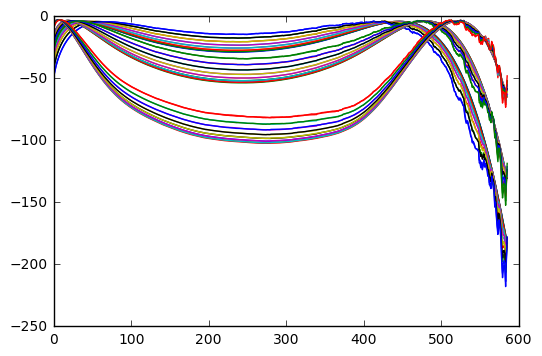

In [39]:
rho_eq = {}
P_eq = {}
x1_eq = {}
d2_eq = {}
mu_eq = {}

for kt_final in [1.20, 1.10, 0.95]:
    rho_eq[kt_final] = []
    P_eq[kt_final] = []
    x1_eq[kt_final] = []
    d2_eq[kt_final] = []
    mu_eq[kt_final] = []
    
    for dmu2 in sorted(mu1_guesses[kt_final]):
        try:
            # Guess in the vicinity of the mu values for direct simulations
            err = 100.0
            guess = mu1_guesses[kt_final][dmu2]
            ctr = 0
            while (np.abs(err) > tol and ctr < maxiter):
                coex, err = hist_ref.find_phase_eq(lnZ_tol, guess, 1.0/kt_final, [dmu2], order, 10.0, False, True, first_order_mom)
                guess = mu1_guesses[kt_final][dmu2] + (random.random()-0.5)*(2*flex)
                ctr += 1
                print 'ctr = ',ctr
        except Exception as e:
            print e
            print 'Failed at ', kt_final, dmu2
            break
        else:
            if (err <= tol):
                cp = coex.coexisting(0.01)
                plt.plot(coex.data['ln(PI)'])
                    
                assert (len(cp) == 1), 'No coexistence found '+str(len(cp))
                assert (len(cp[0]) == 2), 'Found '+str(len(cp[0]))+' coexisting phases instead of 2'
                
                rho_eq[kt_final].append([coex.data['thermo'][cp[0][0]]['density'], coex.data['thermo'][cp[0][1]]['density']])
                P_eq[kt_final].append([-coex.data['thermo'][cp[0][0]]['F.E./kT']/Vol*kt_final, -coex.data['thermo'][cp[0][1]]['F.E./kT']/Vol*kt_final])
                x1_eq[kt_final].append([coex.data['thermo'][cp[0][0]]['x1'], coex.data['thermo'][cp[0][1]]['x1']])
                d2_eq[kt_final].append(dmu2)
                mu_eq[kt_final].append(coex.data['curr_mu'])

In [41]:
## Plot the Results

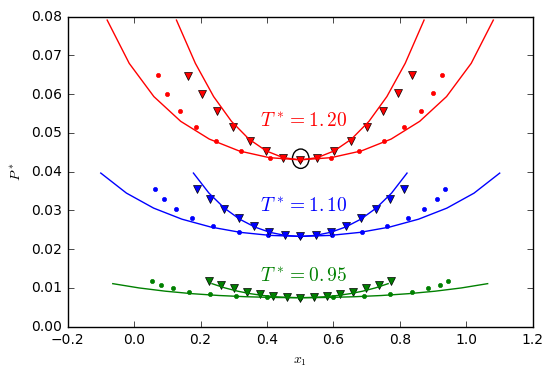

In [43]:
plt.figure()
for temp in [1.20, 1.10, 0.95]:
    plt.plot([a[0] for a in x1[temp]], [b[0] for b in P[temp]], marker='.', lw=0, color=colors[temp])
    plt.plot([a[1] for a in x1[temp]], [b[1] for b in P[temp]], marker='v', lw=0, color=colors[temp])
    plt.plot(x1_eq[temp], P_eq[temp], lw=1, color=colors[temp])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$P^*$')
plt.text(0.38, 0.052, r'$T^* = 1.20$', color='r', fontsize=14)
plt.text(0.38, 0.03, r'$T^* = 1.10$', color='b', fontsize=14)
plt.text(0.38, 0.012, r'$T^* = 0.95$', color='g', fontsize=14)

e = Ellipse(xy=[0.5015,0.0433], width=0.05, height=0.005, angle=0.0, edgecolor='k', fc='None')
plt.gca().add_artist(e)

# Create a "Grid" from one T, then Construct Phase Diagram at Another T

In [48]:
temp = 1.20 # Choose temperature to start from
target_kt = 0.95 # Choose temperature to end at
order = 2 # Choose order
m = 2.5 # Mixing exponent

## Construct Grid by Extrapolating the Reference Data in mu and T

In [49]:
head = './T=%2.2f'%temp
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0
smooth = 30 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms4 = {}
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    composite = head+'/'+d+'/composite.nc'
    try:
        f = open(composite,'r')
    except:
        pass
    else:
        dMu2 = float(d.split('_')[1])
        mu_ref = [0.0, 0.0+dMu2] # Simulations were performed at mu_1 = 0

        hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
        histograms4[dMu2] = hist

target_beta = 1.0/target_kt

# Use all available histograms in the grid
iso = gB.isopleth ([histograms4[x] for x in sorted(histograms4)], target_beta, order)

In [52]:
grid_x1, grid_mu = iso.make_grid_multi([-10, -3], [-3.4, 3.4], [0.2, 0.2], m) 

Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation
Error during ext

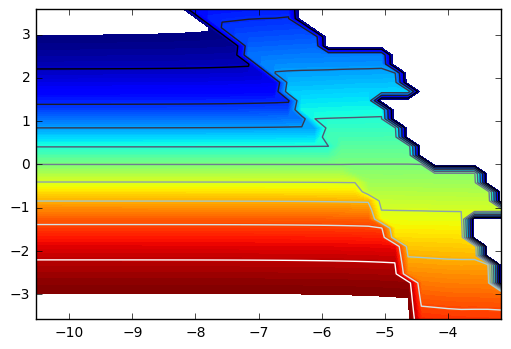

In [53]:
csf = plt.contourf(grid_mu[0]*target_beta, grid_mu[1]*target_beta, grid_x1, levels=np.linspace(0.05, 0.95, 100))
cs = plt.contour(grid_mu[0]*target_beta, grid_mu[1]*target_beta, grid_x1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], cmap='bone')

## Use that Grid to Compute Phase Behavior

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 16
         Function evaluations: 32
Optimization terminated successful

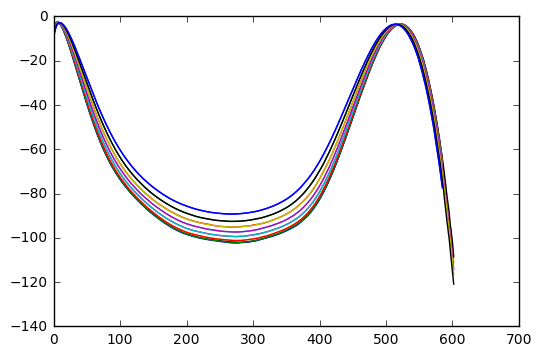

In [60]:
mu1 = 0.0
lnZ_tol = 1.0e-5

p_ = []
x1_ = []
for dmu2 in sorted(mu1_guesses[target_kt]):
    mu1 = mu1_guesses[target_kt][dmu2]
    hh = iso.get_hist (mu1, dmu2, m) # Get macrostate at this mu_2
    
    # Cannot extrapolate a histogram twice, so need this syntax (beta=0.0, dMu=[]) 
    # to just search for coexistence at the current dmu2 (just reweight mu_1)
    coex = hh.find_phase_eq(lnZ_tol, mu1, beta=0.0, dMu=[], extrap_order=order, cutoff=10.0, override=False, reterr=False, first_order_mom=True)
    
    if (coex.is_safe()):
        # Save phase eq data
        cp = coex.coexisting(0.01) # Get "phase indices" that are in coexistence
        plt.plot(coex.data['ln(PI)'])

        assert (len(cp) == 1), 'No coexistence found '+str(len(cp))
        assert (len(cp[0]) == 2), 'Found '+str(len(cp[0]))+' coexisting phases instead of 2'
                
        p_.append([-coex.data['thermo'][cp[0][0]]['F.E./kT']/Vol/target_beta, -coex.data['thermo'][cp[0][1]]['F.E./kT']/Vol/target_beta])
        x1_.append([coex.data['thermo'][cp[0][0]]['x1'], coex.data['thermo'][cp[0][1]]['x1']])

## Plot the Results

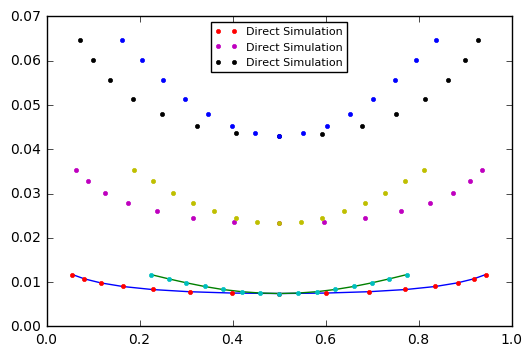

In [65]:
plt.plot([a[0] for a in x1_], [b[0] for b in p_], '-')
plt.plot([a[1] for a in x1_], [b[1] for b in p_], '-')

for kt_ in [0.95, 1.1, 1.2]:
    plt.plot([a[0] for a in x1[kt_]], [b[0] for b in P[kt_]], '.', label='Direct Simulation')
    plt.plot([a[1] for a in x1[kt_]], [b[1] for b in P[kt_]], '.')

plt.legend(loc='best', fontsize=8)